# examine latent space of `SpenderQ`

In [1]:
import os
import pickle
import numpy as np

import fitsio

import torch

from spenderq import load_model
from spenderq import util as U

In [2]:
import umap.plot
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

/home/chhahn/.conda/envs/gqp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/chhahn/.conda/envs/gqp/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/home/chhahn/.conda/envs/gqp/lib/python3.11/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/chhahn/.conda/envs/gqp/lib/python3.11/site-packages/

In [3]:
niter = 3
models, losses = load_model('/tigress/chhahn/spender_qso/models/qso.london.z_2p1_3p5.rebin.iter%i.pt' % niter)

/home/chhahn/projects/SpenderQ/src/spenderq/__init__.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_struct = torch.load(filename, map_location=device)


In [4]:
ibatch = 0 

with open('/tigress/chhahn/spender_qso/train/DESIlondon_highz.rebin.iter%i_%i.pkl' % (niter, ibatch), "rb") as f:
    spec, w, z, target_id, norm, zerr = pickle.load(f)

In [5]:
# load true continuum
true_cont = np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz_%i.true_cont.npy' % (ibatch))

In [7]:
with torch.no_grad():
    models[0].eval()

    s = models[0].encode(spec)
    spec_rest = models[0].decode(s)

# examine latent space in UMAPs

In [8]:
umapper = umap.UMAP().fit(np.array(s))

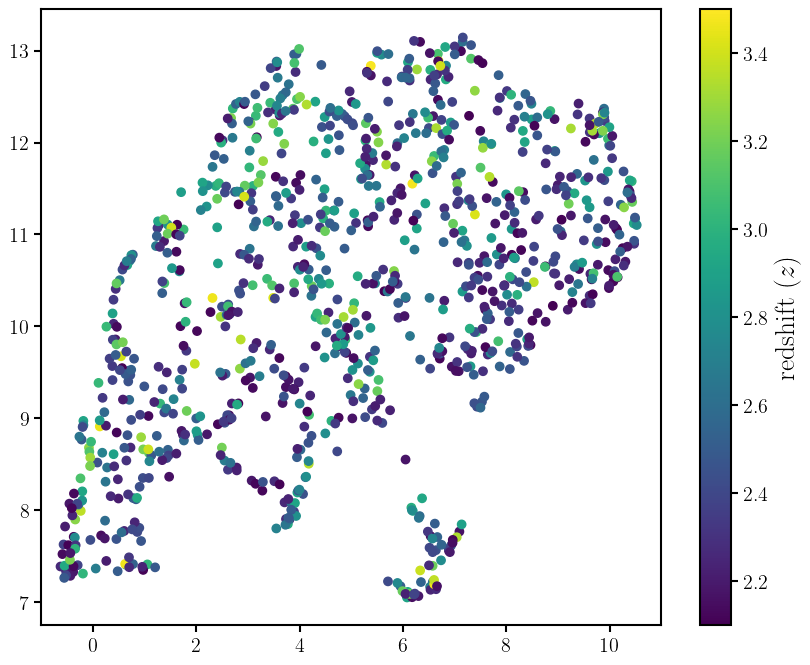

In [14]:
fig = plt.figure(figsize=(10,8))
sub = fig.add_subplot(111)
sc = sub.scatter(umapper.embedding_[:,0], umapper.embedding_[:,1], c=np.array(z), cmap='viridis', vmin=2.1, vmax=3.5)

#sub.set_xticks([])
sub.set_xlim(-1, 11)
#sub.set_yticks([])
cbar = fig.colorbar(sc)
cbar.set_label(label='redshift ($z$)', size=20)

/tmp/ipykernel_944244/1666693107.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  wave_rebin = np.arange(models[0].wave_obs[0], models[0].wave_obs[-1], 10)[1:-1]


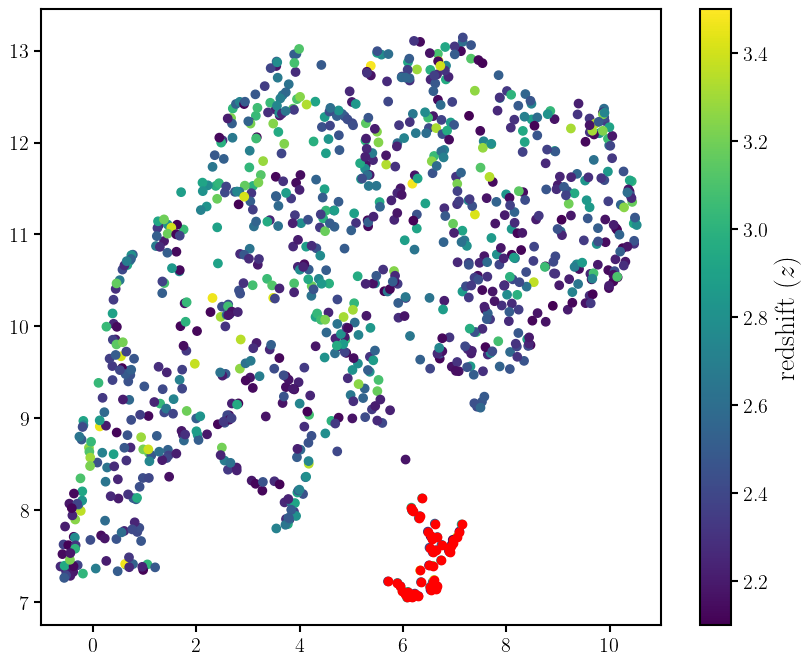

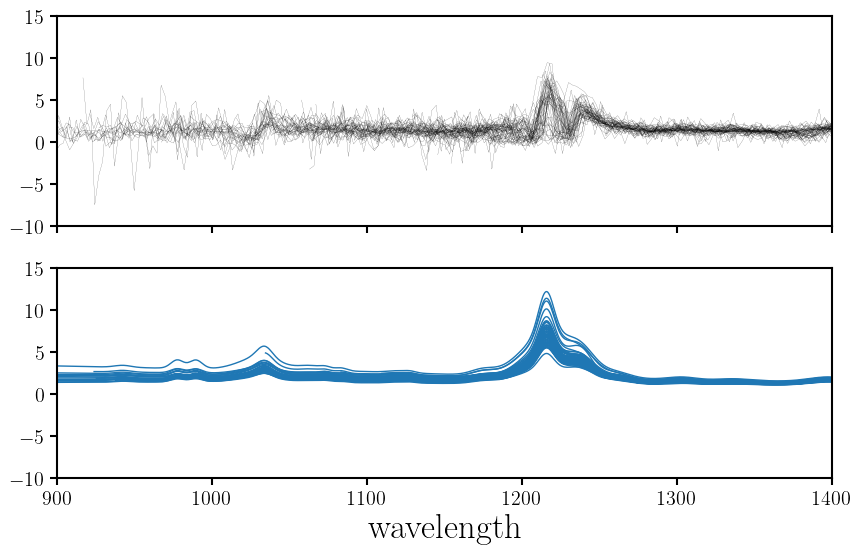

In [22]:
cluster0 = ((umapper.embedding_[:,0] > 5.) & (umapper.embedding_[:,0] <  8.) & 
            (umapper.embedding_[:,1] < 8.4))


fig = plt.figure(figsize=(10,8))
sub = fig.add_subplot(111)
sc = sub.scatter(umapper.embedding_[:,0], umapper.embedding_[:,1], c=np.array(z), cmap='viridis', vmin=2.1, vmax=3.5)
sub.scatter(umapper.embedding_[cluster0,0], umapper.embedding_[cluster0,1], c='r')

sub.set_xlim(-1, 11)
cbar = fig.colorbar(sc)
cbar.set_label(label='redshift ($z$)', size=20)

fig = plt.figure(figsize=(10,6))
sub = fig.add_subplot(211)

wave_rebin = np.arange(models[0].wave_obs[0], models[0].wave_obs[-1], 10)[1:-1]
for ii, igal in enumerate(np.arange(len(z))[cluster0]): 
    spec_rebin = U.trapz_rebin(np.array(models[0].wave_obs), np.array(spec[igal]), xnew=wave_rebin)
    sub.plot(wave_rebin / (1. + z[igal]), spec_rebin, c='k', lw=0.1, label='Coarse-binned')

sub.set_xlim(900., 1400.)
sub.set_xticklabels([])
sub.set_ylim(-10., 15)

sub = fig.add_subplot(212)
for ii, igal in enumerate(np.arange(len(z))[cluster0]): 
    sub.plot(np.linspace(3.50e3, 1e4, 3251) / (1. + z[igal]), true_cont[igal]/norm[igal], c='C0', lw=1, label='True Continuum')

sub.set_xlim(900., 1400.)
sub.set_ylim(-10., 15)
sub.set_xlabel("wavelength", fontsize=25)
plt.show()
plt.close()

/tmp/ipykernel_944244/2840521852.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  wave_rebin = np.arange(models[0].wave_obs[0], models[0].wave_obs[-1], 10)[1:-1]


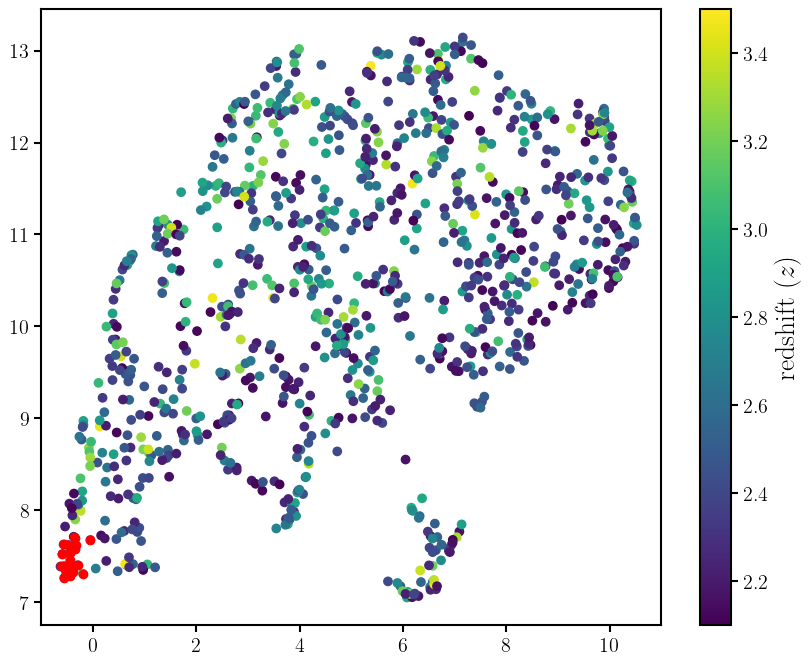

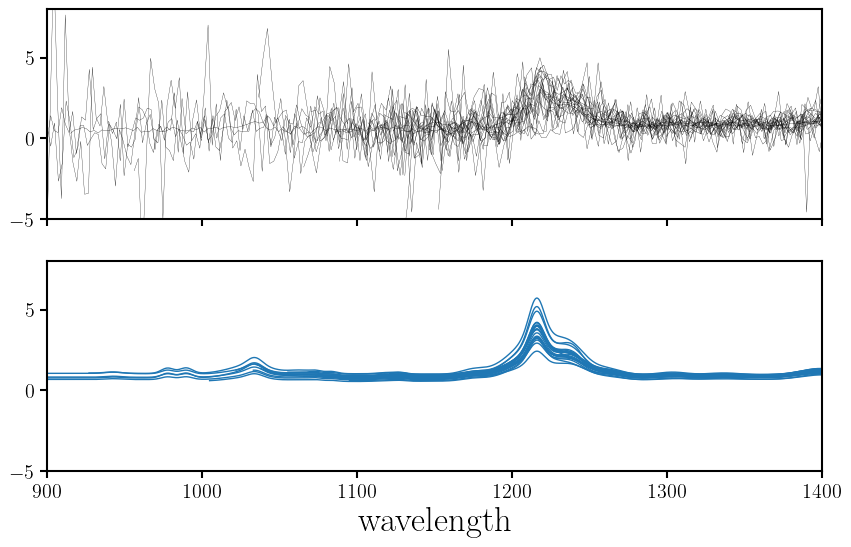

In [27]:
cluster1 = ((umapper.embedding_[:,0] <  0) & 
            (umapper.embedding_[:,1] < 7.8))


fig = plt.figure(figsize=(10,8))
sub = fig.add_subplot(111)
sc = sub.scatter(umapper.embedding_[:,0], umapper.embedding_[:,1], c=np.array(z), cmap='viridis', vmin=2.1, vmax=3.5)
sub.scatter(umapper.embedding_[cluster1,0], umapper.embedding_[cluster1,1], c='r')

sub.set_xlim(-1, 11)
cbar = fig.colorbar(sc)
cbar.set_label(label='redshift ($z$)', size=20)

fig = plt.figure(figsize=(10,6))
sub = fig.add_subplot(211)

wave_rebin = np.arange(models[0].wave_obs[0], models[0].wave_obs[-1], 10)[1:-1]
for ii, igal in enumerate(np.arange(len(z))[cluster1]): 
    spec_rebin = U.trapz_rebin(np.array(models[0].wave_obs), np.array(spec[igal]), xnew=wave_rebin)
    sub.plot(wave_rebin / (1. + z[igal]), spec_rebin, c='k', lw=0.2, label='Coarse-binned')

sub.set_xlim(900., 1400.)
sub.set_xticklabels([])
sub.set_ylim(-5., 8)

sub = fig.add_subplot(212)
for ii, igal in enumerate(np.arange(len(z))[cluster1]): 
    sub.plot(np.linspace(3.50e3, 1e4, 3251) / (1. + z[igal]), true_cont[igal]/norm[igal], c='C0', lw=1, label='True Continuum')

sub.set_xlim(900., 1400.)
sub.set_ylim(-5., 8)
sub.set_xlabel("wavelength", fontsize=25)
plt.show()
plt.close()

/tmp/ipykernel_944244/1154023734.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  wave_rebin = np.arange(models[0].wave_obs[0], models[0].wave_obs[-1], 10)[1:-1]


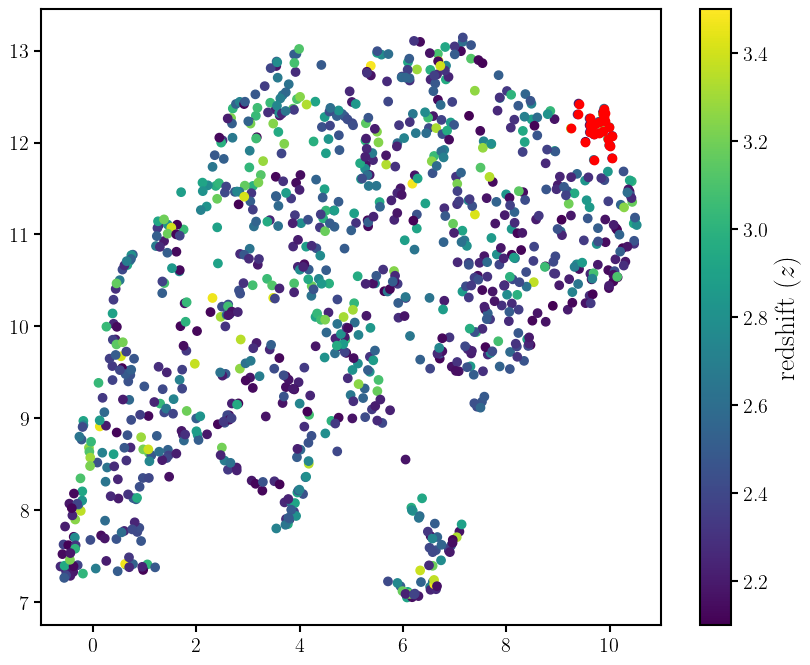

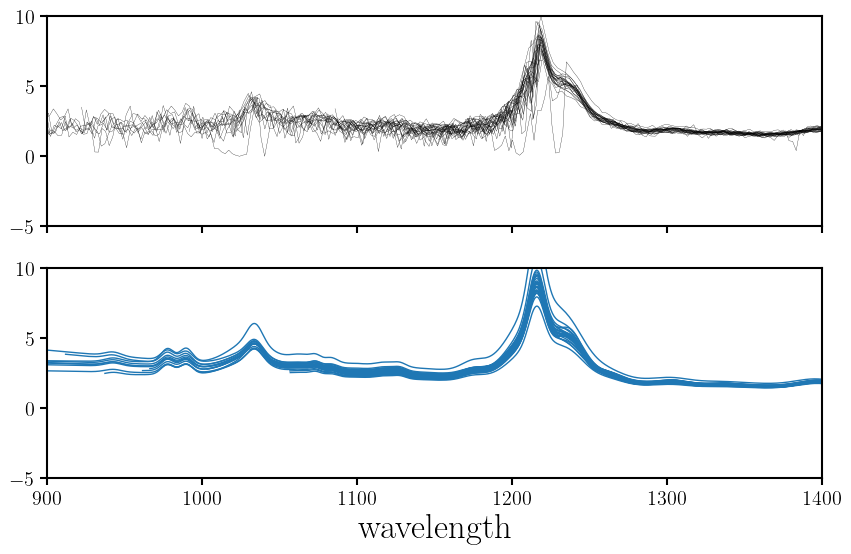

In [29]:
cluster2 = ((umapper.embedding_[:,0] > 9) & 
            (umapper.embedding_[:,1] > 11.8))


fig = plt.figure(figsize=(10,8))
sub = fig.add_subplot(111)
sc = sub.scatter(umapper.embedding_[:,0], umapper.embedding_[:,1], c=np.array(z), cmap='viridis', vmin=2.1, vmax=3.5)
sub.scatter(umapper.embedding_[cluster2,0], umapper.embedding_[cluster2,1], c='r')

sub.set_xlim(-1, 11)
cbar = fig.colorbar(sc)
cbar.set_label(label='redshift ($z$)', size=20)

fig = plt.figure(figsize=(10,6))
sub = fig.add_subplot(211)

wave_rebin = np.arange(models[0].wave_obs[0], models[0].wave_obs[-1], 10)[1:-1]
for ii, igal in enumerate(np.arange(len(z))[cluster2]): 
    spec_rebin = U.trapz_rebin(np.array(models[0].wave_obs), np.array(spec[igal]), xnew=wave_rebin)
    sub.plot(wave_rebin / (1. + z[igal]), spec_rebin, c='k', lw=0.2, label='Coarse-binned')

sub.set_xlim(900., 1400.)
sub.set_xticklabels([])
sub.set_ylim(-5., 10)

sub = fig.add_subplot(212)
for ii, igal in enumerate(np.arange(len(z))[cluster2]): 
    sub.plot(np.linspace(3.50e3, 1e4, 3251) / (1. + z[igal]), true_cont[igal]/norm[igal], c='C0', lw=1, label='True Continuum')

sub.set_xlim(900., 1400.)
sub.set_ylim(-5., 10)
sub.set_xlabel("wavelength", fontsize=25)
plt.show()
plt.close()

# examine full latent space

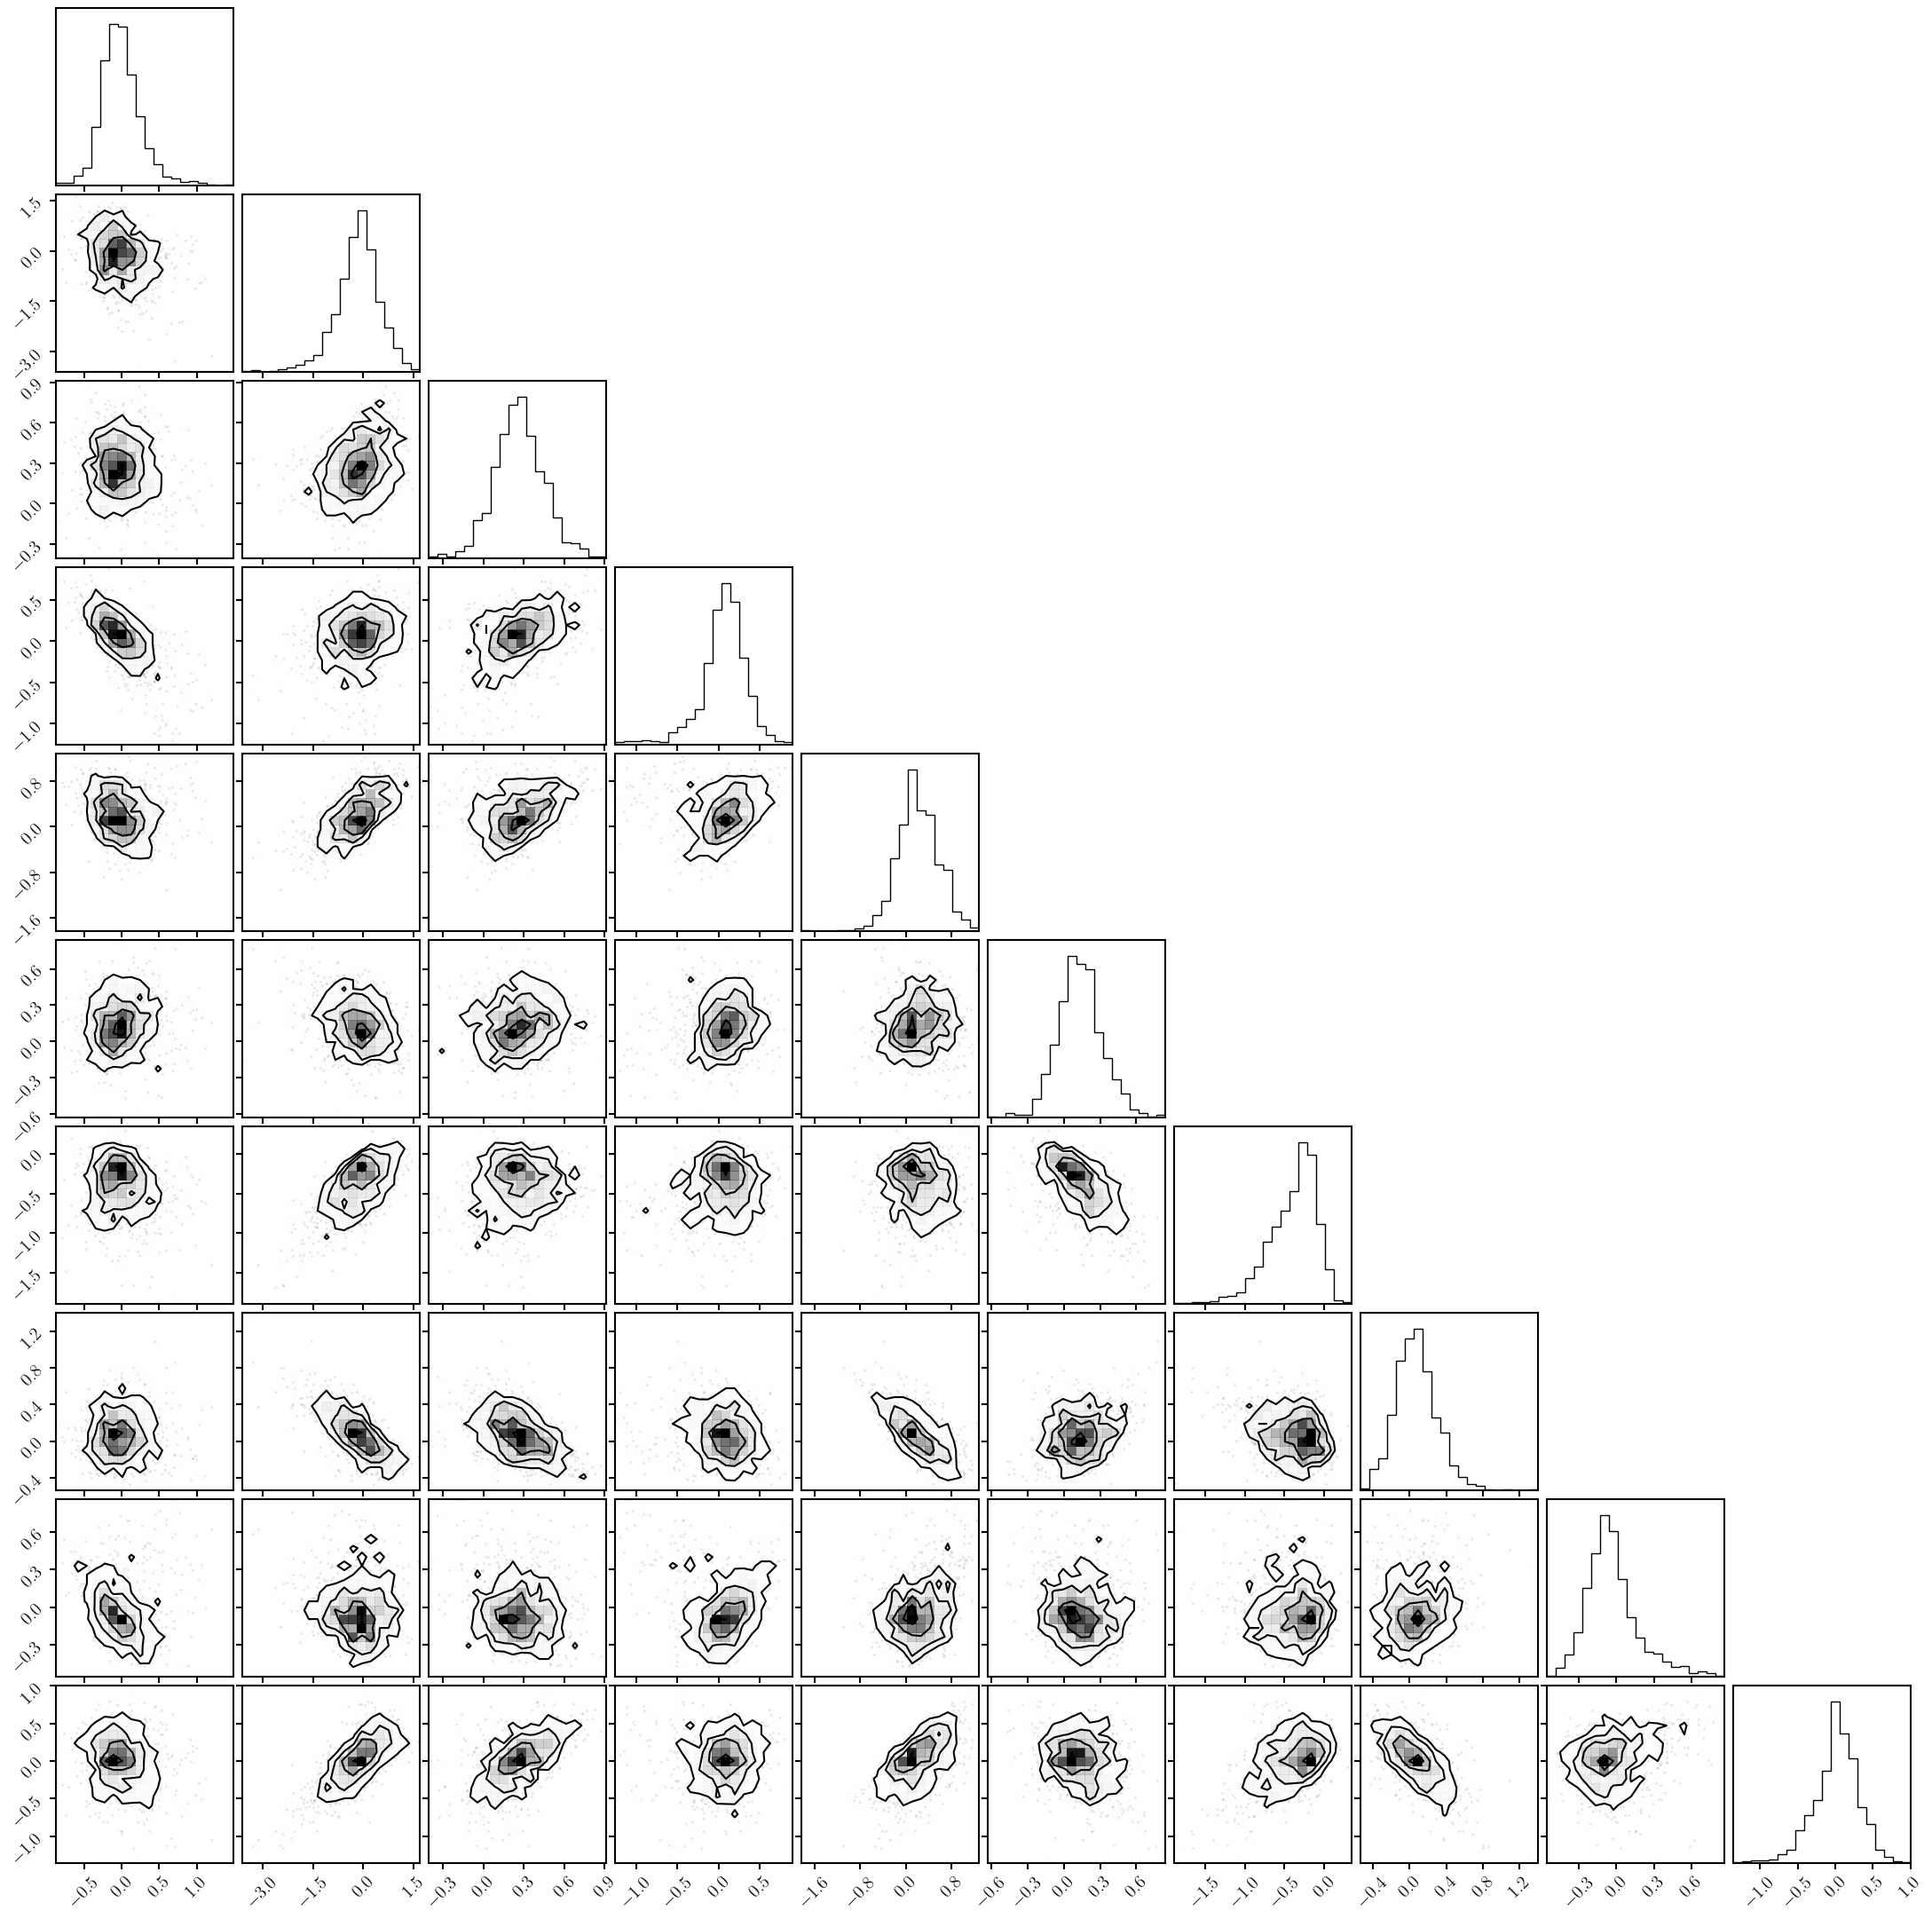

In [30]:
fig = DFM.corner(np.array(s))

In principle this space can be used for anomaly detection (in real data, would be meaningless in simulated data). It can also be used to examine limitations of current simulations.